# Overview
On April 15, 1912, the passenger liner Titanic collided with an iceberg during her maiden voyage as the world's largest and fastest ship.More than 1500 passengers and crew died, making this one of the deadliest sinkings of a single passenger ship to date.

Data recorded from this tragedy includes passenger info such as gender, class of travel, and survival status.This provides the opportunity to determine whether or not variables such as gender were correlated with a passenger's chances of survival. If correlation is established, it will deepen our understanding of the culture and social practices at the time (e.g. priority given to women, children and the rich)

This project comprises two parts, namely:

(i) Exploratory data analysis -conducted data pre-processing, which included replacing NaN values for age with mean values -explored and visualized relationships between survival status and variables such as class and gender

(ii) Machine learning model to predict the survival status of a passenger -conducted data pre-processing, which included converting categorical data to binary numbers -tested three models, namely decision tree, multilayer perceptron and random forest classifier -evaluated the models using F1 and AUC-ROC scores -tuned the model using feature selection and improved F1 and AUC-ROC scores

## Dataset

The principal source for data about Titanic passengers is the Encyclopedia Titanica.This data does not contain information from the crew, but it does contain actual ages of half of the passengers, as well as other information such as class of travel and gender.

The dataset used for this project is from the Seaborn online repository which had already undergone a small amount of pre-processing.

## Findings

(i) Women and first class passengers had a significantly higher chance of survival

(ii) Out of the three models tested, the multilayer perceptron had the highest F1 and AUC-ROC scores

In [152]:
#import relevant packages

#for data analysis and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import ipy_table as tbl
from prettytable import PrettyTable 


#for machine learning
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics

#silence pandas warnings
import warnings
warnings.filterwarnings('ignore')

In [153]:
#load dataset from seaborn repository
data = sns.load_dataset('titanic')
data.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [154]:
#inspect data
data.describe()


,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [155]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [156]:
#data pre-processing
#check for missing values
data.isnull().sum()


survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [157]:
#replace NaN values for age with mean
data['age'].fillna((data['age'].mean()), inplace=True)

In [158]:
#drop columns that wont be used in analysis 
data.drop(['who', 'deck','embark_town','sibsp','parch','alive','fare','embarked','adult_male'], axis=1, inplace=True)


In [159]:
#check dataframe
data.head()

,survived,pclass,sex,age,class,alone
0,0,3,male,22.0,Third,False
1,1,1,female,38.0,First,False
2,1,3,female,26.0,Third,True
3,1,1,female,35.0,First,False
4,0,3,male,35.0,Third,True


# Exploratory Data analysis 


Text(0.5, 1.0, '% of survivors and non survivors by class')

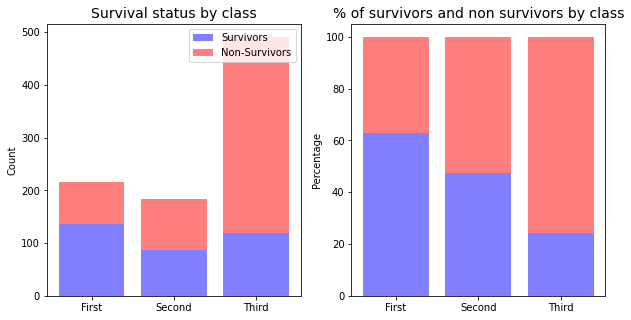

In [160]:
#compare the profiles of those who survived with those who did not, starting with class of travel

#create variables for survivors and non survivors data
survivors_data = data[data.survived==True]
non_survivors_data = data[data.survived==False]


# calculate values for each category by class
survivors_class = survivors_data.groupby(['class']).size().values
non_survivors_class = non_survivors_data.groupby(['class']).size().values

# calculate totals for percentages
total = survivors_class + non_survivors_class

#create a function to calculate percentage
def calculate_percentage(val, total, format_percent = False):
    percent = np.divide(val, total, dtype=float)
    if format_percent:
        percent = as_percent(percent)
    return percent

# use calculate_percentage_function to calculate percentage of the total
s_percentages = calculate_percentage(survivors_class, total)*100 
ns_percentages = calculate_percentage(non_survivors_class, total)*100 

# plot bar chart for count of survivors by class
class_categories = ['First', 'Second', 'Third']
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.bar(range(len(survivors_class)), survivors_class, label='Survivors', alpha=0.5, color='b')
ax1.bar(range(len(non_survivors_class)), non_survivors_class, bottom=survivors_class, label='Non-Survivors', alpha=0.5, color='r')
plt.sca(ax1)
plt.xticks([0, 1, 2], class_categories )
ax1.set_ylabel("Count")
ax1.set_xlabel("")
ax1.set_title("Survival status by class",fontsize=14)
plt.legend(loc='upper right')


# add bar chart for percentage of survivors by class
ax2.bar(range(len(s_percentages)), s_percentages, alpha=0.5, color='b')
ax2.bar(range(len(ns_percentages)), ns_percentages, bottom=s_percentages, alpha=0.5, color='r')
plt.sca(ax2)
plt.xticks([0, 1,2],class_categories)
ax2.set_ylabel("Percentage")
ax2.set_xlabel("")
ax2.set_title("% of survivors and non survivors by class",fontsize=14)




In [161]:
"""
the barplots seem to show a significant difference in survival rate by class. 
let's confirm the association between class and survival rate by checking the P value 
"""

#run chi square test 
table = pd.crosstab([data['survived']], data['pclass'])
chi2, p, dof, expected = stats.chi2_contingency(table.values)
results = [
    ['Item','Value'],
    ['Chi-Square Test',chi2],
    ['P-Value', p]
]
tbl.make_table(results)

#since P<0.05, we can conclude that there is an association between the class of travel and the survival rate 

Item,Value
Chi-Square Test,102.8890
P-Value,0.0000


In [162]:
#analyze profile of survivors by gender 

#first look at overall gender makeup of survivors
data.groupby('sex').survived.mean()

sex
female    0.742038
male      0.188908
Name: survived, dtype: float64

Text(0.5, 1.0, '% of survivors and non-survivors by gender')

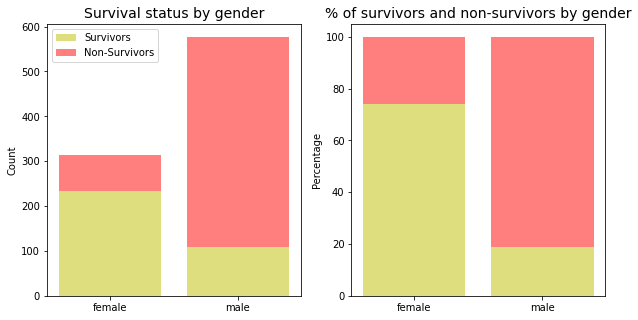

In [205]:
#group survivor data by gender
survivors_gender = survivors_data.groupby(['sex']).size().values
non_survivors_gender = non_survivors_data.groupby(['sex']).size().values

# calculate totals for percentages
totals = survivors_gender + non_survivors_gender

# use calculate_percentage_function to calculate percentage of survivors by gender
data1_percentages = calculate_percentage(survivors_gender, totals)*100 
data2_percentages = calculate_percentage(non_survivors_gender, totals)*100 

gender_categories = ['female', 'male']

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
# plot chart for count of survivors by gender
ax1.bar(range(len(survivors_gender)), survivors_gender, label='Survivors', alpha=0.5, color='y')
ax1.bar(range(len(non_survivors_gender)), non_survivors_gender, bottom=survivors_gender, label='Non-Survivors', alpha=0.5, color='r')
plt.sca(ax1)
plt.xticks([0, 1], gender_categories )
ax1.set_ylabel("Count")
ax1.set_xlabel("")
ax1.set_title("Survival status by gender",fontsize=14)
plt.legend(loc='upper left')

# plot chart for percentage of survivors by gender
ax2.bar(range(len(data1_percentages)), data1_percentages, alpha=0.5, color='y')
ax2.bar(range(len(data2_percentages)), data2_percentages, bottom=data1_percentages, alpha=0.5, color='r')
plt.sca(ax2)
plt.xticks([0, 1],  gender_categories)
ax2.set_ylabel("Percentage")
ax2.set_xlabel("")
ax2.set_title("% of survivors and non-survivors by gender",fontsize=14)


#we can see that there were more male than female passengers on the titanic, but female passengers had a higher survival rate. The latter is in line with what we know about the evacuation procedures during that time, namely that priority was given to women and children


In [203]:
"""
the barplots seem to show a significant difference in survival rate by gender. 
let's confirm the association between gender and survival rate by checking the P value 
"""

#run chi square test 
table = pd.crosstab([data['survived']], data['sex'])
chi2, p, dof, expected = stats.chi2_contingency(table.values)
results = [
    ['Item','Value'],
    ['Chi-Square Test',chi2],
    ['P-Value', p]
]
tbl.make_table(results)

#since P<0.05, we can conclude that there is an association between the class of travel and the survival rate 

Item,Value
Chi-Square Test,260.7170
P-Value,0.0000


# Machine learning models

In [164]:
#data pre-processing
#encode categorical data with binary numbers

#encode sex- female (0), male (1)
data['sex'].replace(['female','male'],[0,1],inplace=True)

#encode alone- false(0),true (1)
data['alone'].replace([False,True],[0,1],inplace=True)

In [165]:
#drop class column since data is already captured in binary numbers in pclass
data.drop(['class'], axis=1, inplace=True)

In [166]:
#check dataframe
data.head()

,survived,pclass,sex,age,alone
0,0,3,1,22.0,0
1,1,1,0,38.0,0
2,1,3,0,26.0,1
3,1,1,0,35.0,0
4,0,3,1,35.0,1


In [167]:
#train test split
#separate features from target value
X=data.drop('survived',axis=1)
Y=data['survived']
#perform a 80-10-10 split
X_new, X_test,Y_new, Y_test = train_test_split(X, Y, test_size=0.1, random_state = 0)
test_size = X_test.shape[0] / X_new.shape[0]
X_train, X_dev, Y_train, Y_dev = train_test_split(X_new, Y_new, test_size=test_size, random_state = 0)
print(X_train.shape,Y_train.shape,X_dev.shape,Y_dev.shape,X_test.shape,Y_test.shape)

(711, 4) (711,) (90, 4) (90,) (90, 4) (90,)


In [168]:
#use decision tree algorithm to train model
model_tree=DecisionTreeClassifier(random_state=2)
model_tree.fit(X_train,Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=2, splitter='best')

In [180]:
"""
evaluate the decision tree model using F1 score and AUC-ROC

Precision: True Positive / (True Positive + False Positive)
Recall: True Positive / (True Positive + False Negative)
F1 Score: 2 x [(Precision x Recall) / (Precision + Recall)]
AUC-ROC: AUC (Area Under The Curve) ROC (Receiver Operating Characteristics) curve. 
AUC ROC indicates how well the probabilities from the positive classes are separated from the negative classes.
"""
# predict y values using testing set x variables
predicted_values_DT = model_tree.predict(X_test)

# F1 Score
f1_score_DT= metrics.f1_score(Y_test, predicted_values_DT)

# AUC ROC score
auc_score_DT = metrics.roc_auc_score(Y_test, predicted_values_DT)
print(f'The F1 score for the decision tree is {f1_score_DT:0.2f}.')
print(f'The AUC-ROC score for the decision tree is {auc_score_DT:0.2f}.')

The F1 score for the decision tree is 0.71.
The AUC-ROC score for the decision tree is 0.77.


In [181]:
#use multilayer perceptron (MLP) algorithm
model_NN=MLPClassifier(random_state=2)
model_NN.fit(X_train,Y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=2, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [182]:
#evaluate the MLP model 

#predict y values using testing set x variables
predicted_values_MLP = model_NN.predict(X_test)

# F1 Score
f1_score_MLP = metrics.f1_score(Y_test, predicted_values_MLP)

# AUC ROC score
auc_score_MLP = metrics.roc_auc_score(Y_test, predicted_values_MLP)
print(f'The F1 score for the MLP is {f1_score_MLP:0.2f}.')
print(f'The AUC-ROC score for the MLP is {auc_score_MLP:0.2f}.')

The F1 score for the MLP is 0.78.
The AUC-ROC score for the MLP is 0.81.


In [201]:
#let's try a random forest classifier to see how it fares
rfc = RandomForestClassifier()
rfc.fit(X_train, Y_train)
predicted_values_RF= rfc.predict(X_test)
# F1 Score
f1_score_RF = metrics.f1_score(Y_test, predicted_values_RF)

# AUC ROC score
auc_score_RF= metrics.roc_auc_score(Y_test, predicted_values_RF)
print(f'The F1 score for the RFC is {f1_score_RF:0.2f}.')
print(f'The AUC-ROC score for the RFC is {auc_score_RF:0.2f}.')

The F1 score for the RFC is 0.74.
The AUC-ROC score for the RFC is 0.77.


In [202]:
#compare the scores across all three models in a table 

# Specify the Column Names 
myTable = PrettyTable(['','Decision Tree', 'Multilayer Perceptron','Random Forest Classifier']) 
  
# Add rows 
myTable.add_row(['f1 score',f1_score_DT, f1_score_MLP,f1_score_RF]) 
myTable.add_row(['AUC-ROC score', auc_score_DT, auc_score_MLP,auc_score_RF]) 

print(myTable)

+---------------+--------------------+-----------------------+--------------------------+
|               |   Decision Tree    | Multilayer Perceptron | Random Forest Classifier |
+---------------+--------------------+-----------------------+--------------------------+
|    f1 score   | 0.7096774193548387 |   0.7777777777777778  |    0.736842105263158     |
| AUC-ROC score | 0.7722473604826545 |   0.8099547511312217  |    0.770739064856712     |
+---------------+--------------------+-----------------------+--------------------------+
